# Two-Joint Arm with Minimum Jerk Trajectory, Feedforward Control, and Dynamic Integration
This script models a two-joint arm (shoulder and elbow) and simulates its movement
from Point A to Point B using a minimum jerk trajectory, feedforward control, and dynamic integration.

In [172]:
import numpy as np
import matplotlib.pyplot as plt

In [173]:
np.random.seed(123)

## Arm Parameters
Defining the physical parameters of the arm:
- Upper arm: 1.5 kg, 30 cm
- Forearm: 1.0 kg, 25 cm

In [174]:
# Physical properties
upper_arm_mass = 1.5  # kg
forearm_mass = 0.5    # kg
upper_arm_length = 0.3  # meters
forearm_length = 0.25   # meters
dt = 0.01  # time step (s)
sim_time = 2.0  # simulation time (s)
time = np.arange(0, sim_time, dt)

# Moments of inertia (rod rotating around one end)
I1 = (1/3) * upper_arm_mass * (upper_arm_length ** 2)
I2 = (1/3) * forearm_mass * (forearm_length ** 2)

## Minimum Jerk Trajectory
The path from Point A to Point B is planned using a minimum jerk trajectory.

In [175]:
def minimum_jerk_trajectory(start, end, time):
    """ Generate a minimum jerk trajectory from start to end. """
    T = time[-1]
    s = time / T
    path = start + (end - start) * (10 * s**3 - 15 * s**4 + 6 * s**5)
    return path

# Start and end positions in Cartesian space
start_position = np.array([0.2, 0.1])
end_position = np.array([0.2, 0.3])

# Generate Cartesian trajectory
x_traj = minimum_jerk_trajectory(start_position[0], end_position[0], time)
y_traj = minimum_jerk_trajectory(start_position[1], end_position[1], time)

## Inverse Kinematics
Compute the joint angles required to achieve the planned Cartesian path.

In [176]:
def inverse_kinematics(x, y, L1, L2):
    """ Compute the shoulder and elbow angles for given (x, y). """
    cos_angle = (x**2 + y**2 - L1**2 - L2**2) / (2 * L1 * L2)
    sin_angle = np.sqrt(1 - cos_angle**2)
    theta2 = np.arctan2(sin_angle, cos_angle)

    k1 = L1 + L2 * cos_angle
    k2 = L2 * sin_angle
    theta1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    
    return theta1, theta2

# Compute the joint trajectories
theta1_traj, theta2_traj = inverse_kinematics(x_traj, y_traj, upper_arm_length, forearm_length)

## Feedforward Control Torques
Generate feedforward torques using the inertia of the arm segments.

In [177]:
def compute_feedforward_torques(theta1_desired, theta2_desired):
    """ Compute the necessary feedforward torques to achieve the trajectory. """
    # Desired accelerations (second derivative of the trajectory)
    theta1_ddot = np.gradient(np.gradient(theta1_desired, dt), dt)
    theta2_ddot = np.gradient(np.gradient(theta2_desired, dt), dt)

    # Torque calculation (Inertia * acceleration)
    tau1 = I1 * theta1_ddot + np.random.normal(0, 0.01, len(theta1_ddot))
    tau2 = I2 * theta2_ddot + np.random.normal(0, 0.01, len(theta2_ddot))
    
    return tau1, tau2

# Generate the feedforward torques
tau1_traj, tau2_traj = compute_feedforward_torques(theta1_traj, theta2_traj)

## Inverse model torques
Esimate intersegmental coordination torques from the joint velocities

In [178]:
def inverse_model_torques(theta1_dot, theta2_dot, B):
    """ Compute torque corrections based on joint velocities. """
    # Enforce interactions and not self-interactions
    B = np.array([[0, B[0,1]], [B[1,0], 0]])
    velocities = np.array([theta1_dot, theta2_dot])
    delta_torques = B @ velocities
    return delta_torques[0], delta_torques[1]

# Initialize B to a value that works for the system
# This is a placeholder; in practice, this would be learned or derived from system dynamics
B = np.array([[0.0, 0.0],
              [0.0, 0.0]])

## Forward Dynamics Integration
Compute the actual movement by integrating the dynamics.

In [179]:
def forward_dynamics_with_correction(tau1, tau2, B):
    """ Simulate the dynamics of the two-joint arm with torque correction. """
    theta1, theta2 = theta1_traj[0], theta2_traj[0]
    omega1, omega2 = 0.0, 0.0
    
    actual_theta1, actual_theta2 = [theta1], [theta2]

    for t1, t2 in zip(tau1, tau2):
        # Compute inverse model torque corrections
        dtau1, dtau2 = inverse_model_torques(omega1, omega2, B)
        
        # Apply corrections
        t1 += dtau1
        t2 += dtau2

        # Compute angular acceleration
        alpha1 = t1 / I1
        alpha2 = t2 / I2
        
        # Update velocities and angles
        omega1 += alpha1 * dt
        omega2 += alpha2 * dt
        theta1 += omega1 * dt
        theta2 += omega2 * dt
        
        # Store the trajectory
        actual_theta1.append(theta1)
        actual_theta2.append(theta2)

    return np.array(actual_theta1[:-1]), np.array(actual_theta2[:-1])

# Compute the corrected movement path
actual_theta1, actual_theta2 = forward_dynamics_with_correction(tau1_traj, tau2_traj, B)

## Visualization
Plot the Desired vs. Actual trajectories

In [180]:
def forward_kinematics(theta1, theta2, L1, L2):
    """ Compute the (x, y) position of the end effector. """
    x = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)
    y = L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2)
    return x, y

# Compute desired and actual Cartesian paths
x_desired, y_desired = x_traj, y_traj
x_actual, y_actual = forward_kinematics(actual_theta1, actual_theta2, upper_arm_length, forearm_length)

# Compute velocities
x_vel_desired = np.gradient(x_desired, dt)
y_vel_desired = np.gradient(y_desired, dt)
x_vel_actual = np.gradient(x_actual, dt)
y_vel_actual = np.gradient(y_actual, dt)


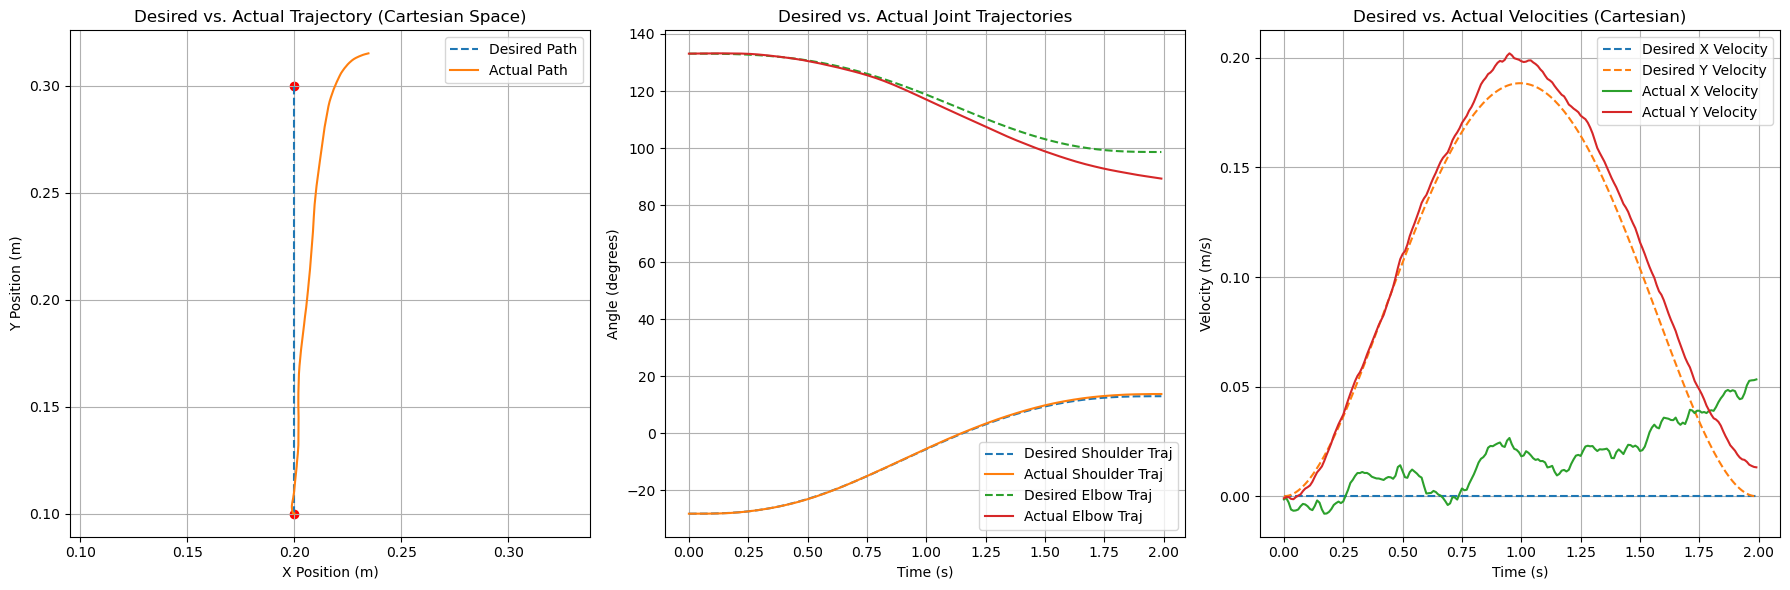

In [181]:
def show_results(x_desired, y_desired, x_actual, y_actual, 
                 actual_theta1, actual_theta2, theta1_traj, theta2_traj,
                 x_vel_desired, y_vel_desired, x_vel_actual, y_vel_actual,
                 start_position, end_position):
    """ Plot the results of the simulation. """
    plt.figure(figsize=(18, 6))

    # Cartesian trajectory
    plt.subplot(1, 3, 1)
    plt.plot(x_desired, y_desired, label='Desired Path', linestyle='--')
    plt.plot(x_actual, y_actual, label='Actual Path')
    plt.scatter([start_position[0], end_position[0]], [start_position[1], end_position[1]], c='red')
    plt.title('Desired vs. Actual Trajectory (Cartesian Space)')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()

    # Joint angle trajectories
    plt.subplot(1, 3, 2)
    plt.plot(time, np.rad2deg(theta1_traj), label='Desired Shoulder Traj', linestyle='--')
    plt.plot(time, np.rad2deg(actual_theta1), label='Actual Shoulder Traj')
    plt.plot(time, np.rad2deg(theta2_traj), label='Desired Elbow Traj', linestyle='--')
    plt.plot(time, np.rad2deg(actual_theta2), label='Actual Elbow Traj')
    plt.title('Desired vs. Actual Joint Trajectories')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.grid(True)
    plt.legend()

    # Velocity plots
    plt.subplot(1, 3, 3)
    plt.plot(time, x_vel_desired, label='Desired X Velocity', linestyle='--')
    plt.plot(time, y_vel_desired, label='Desired Y Velocity', linestyle='--')
    plt.plot(time, x_vel_actual, label='Actual X Velocity')
    plt.plot(time, y_vel_actual, label='Actual Y Velocity')
    plt.title('Desired vs. Actual Velocities (Cartesian)')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Show the results
show_results(x_desired, y_desired, x_actual, y_actual, 
             actual_theta1, actual_theta2, theta1_traj, theta2_traj,
             x_vel_desired, y_vel_desired, x_vel_actual, y_vel_actual,
             start_position, end_position)

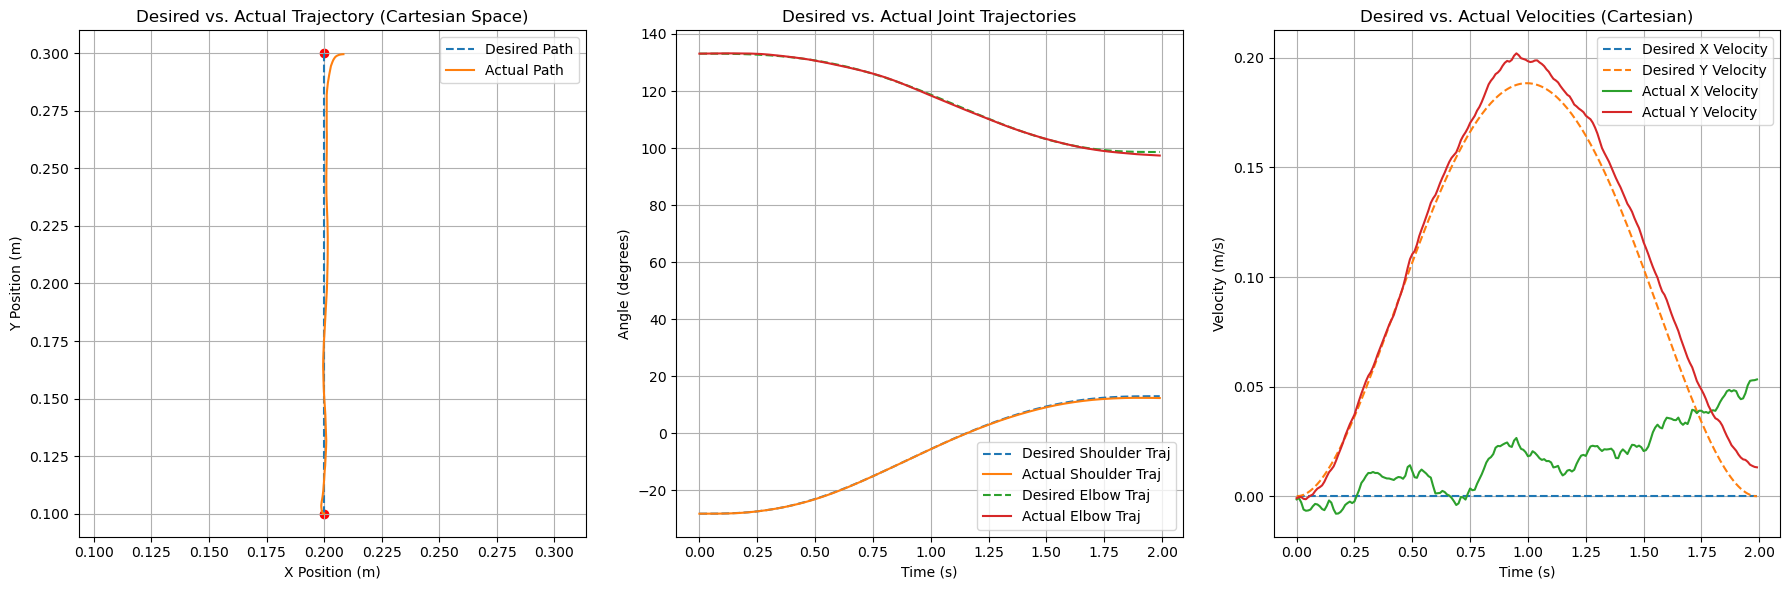

In [182]:
B = np.array([[0.0, 0.002],
              [0.002, 0.0]])

# Compute the corrected movement path
actual_theta1, actual_theta2 = forward_dynamics_with_correction(tau1_traj, tau2_traj, B)
x_actual, y_actual = forward_kinematics(actual_theta1, actual_theta2, upper_arm_length, forearm_length)

show_results(x_desired, y_desired, x_actual, y_actual, 
             actual_theta1, actual_theta2, theta1_traj, theta2_traj,
             x_vel_desired, y_vel_desired, x_vel_actual, y_vel_actual,
             start_position, end_position)

# Learning B

In [ ]:
def update_B(B, actual_theta1, actual_theta2, theta1_traj, theta2_traj)
    """ Update the B matrix based on the difference between desired and actual trajectories. """
    # Update B based on the errors
    new_B = np.zeros_like(B)
    new_B[0, 1] = B[0,1]
    new_B[1, 0] = B[1,0]

    return B

In [ ]:
B = np.array([[0.0, 0.0],
              [0.0, 0.0]])

num_iterations = 10
for i in range(num_iterations):
    # Compute the corrected movement path
    actual_theta1, actual_theta2 = forward_dynamics_with_correction(tau1_traj, tau2_traj, B)
    x_actual, y_actual = forward_kinematics(actual_theta1, actual_theta2, upper_arm_length, forearm_length)

    # Update B based on the difference between desired and actual trajectories
    B = update_B(B, actual_theta1, actual_theta2, theta1_traj, theta2_traj) 
    print(f"Iteration {i+1}/{num_iterations}, B: {B}")

show_results(x_desired, y_desired, x_actual, y_actual, 
             actual_theta1, actual_theta2, theta1_traj, theta2_traj,
             x_vel_desired, y_vel_desired, x_vel_actual, y_vel_actual,
             start_position, end_position)